In [1]:
import urllib
import os.path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Utile
def random_binomial(shape, p=0.0, dtype=None, seed=None):
    """Returns a tensor with random binomial distribution of values.
    # Arguments
        shape: A tuple of integers, the shape of tensor to create.
        p: A float, `0. <= p <= 1`, probability of binomial distribution.
        dtype: String, dtype of returned tensor.
        seed: Integer, random seed.
    # Returns
        A tensor.
    """
    if dtype is None:
        dtype = 'float32'
    if seed is None:
        seed = np.random.randint(10e6)
    return tf.where(tf.random_uniform(shape, dtype=dtype, seed=seed) <= p,
                    tf.ones(shape, dtype=dtype),
                    tf.zeros(shape, dtype=dtype))
#reshape Data

def my_reshape(data_in ,number_of_frame = 2):
    N, M, H, W = data_in.shape
    n = M-number_of_frame+1
    data_out = np.zeros((n * N, number_of_frame, 64, 64),'uint8')
    for j in range(N):
        for i in range(n):
            data_out[j*n+i] = data_in[j, i:i+number_of_frame]
    
    return data_out

#show filter 
def dispims(M, height, width, border=0, bordercolor=0.0, layout=None, **kwargs):
    from pylab import cm, ceil
    numimages = M.shape[1]
    if layout is None:
        n0 = int(np.ceil(np.sqrt(numimages)))
        n1 = int(np.ceil(np.sqrt(numimages)))
    else:
        n0, n1 = layout
    im = bordercolor * np.ones(((height+border)*n0+border,(width+border)*n1+border),dtype='<f8')
    for i in range(n0):
        for j in range(n1):
            if i*n1+j < M.shape[1]:
                im[i*(height+border)+border:(i+1)*(height+border)+border,
                   j*(width+border)+border :(j+1)*(width+border)+border] = np.vstack((
                            np.hstack((np.reshape(M[:,i*n1+j],(height, width)),
                                   bordercolor*np.ones((height,border),dtype=float))),
                            bordercolor*np.ones((border,width+border),dtype=float)
                            ))
    pylab.imshow(im, cmap=cm.gray, interpolation='nearest', **kwargs)
    pylab.show()

In [2]:

# LOAD DATA
file_name = 'mnist_test_seq.npy'
if not os.path.isfile(file_name):
    print("could not find moving mnist: download it..")
    url = 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'
    urllib.urlretrieve(url, file_name)
    print("download complete")
else :
    print ("Data Exist")
    
data = np.load(file_name)
print data.shape





Data Exist
(20, 10000, 64, 64)


In [3]:

# Get mean and variance of all frames 
data_1 = my_reshape(data, 1)
v,n,h,w = data_1.shape
data_1 = data_1.reshape((v,h * w))
print data_1 .dtype

mean_all = data_1.mean(0)[None,:]
data_1 -= mean_all.astype('uint8')
print data_1.shape
print data_1.dtype


uint8
(200000, 4096)
uint8


In [4]:
var_all = data_1[0:1000,:].std(0)[None, :]   + data_1[0:1000,:].std() * 0.1

#data for first layer pretraining 
data_1 = my_reshape(data, 2)
v,n,h,w = data_1.shape
data_1 = data_1.reshape((v,n,h * w))

x_dim = data_1.shape[2] 


X1 = data_1[:,0,:]
X2 = data_1[:,1,:]
data_1 = 0
print X1.shape
print X2.shape

#Preprocess Data

X1 -= mean_all.astype('uint8')
X1 /= var_all.astype('uint8')

X2 -=mean_all.astype('uint8')
X2 /= var_all.astype('uint8')

ntrain = X1.shape[0]
print X1.dtype

(199980, 4096)
(199980, 4096)
uint8


In [ ]:
numpy_rng = np.random.RandomState(1)

numfac  = 512
nummap  = 256



# pretrainig first layer
input_x1 = tf.placeholder(tf.float32, [None, x_dim])
input_x2 = tf.placeholder(tf.float32, [None, x_dim])

U1 = tf.Variable(tf.random_normal(shape=(x_dim, numfac)) * 0.01)
V1 = tf.Variable(tf.random_normal(shape=(x_dim, numfac)) * 0.01)
W1 = tf.Variable(numpy_rng.uniform(low=-0.01, high=+0.01, size=( numfac, nummap)).astype('float32'))

bias_U1 = tf.Variable(np.zeros(numfac, dtype='float32'))
bias_V1 = tf.Variable(np.zeros(numfac, dtype='float32'))
bias_W1 = tf.Variable(np.zeros(nummap, dtype='float32'))
bias_U1_out = tf.Variable(np.zeros(x_dim, dtype='float32'))
bias_V1_out = tf.Variable(np.zeros(x_dim, dtype='float32'))
bias_W1_out = tf.Variable(np.zeros(numfac, dtype='float32'))

# m=sig(W(U*X1 . V*X2 ))
M1 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x1,U1) + bias_U1,tf.matmul(input_x2,V1) + bias_V1), W1)+ bias_W1)

output_x1 = tf.matmul(tf.multiply(tf.matmul(M1,tf.transpose(W1)) + bias_W1_out,tf.matmul(input_x2,V1) + bias_V1),tf.transpose(U1))+ bias_U1_out
output_x2 = tf.matmul(tf.multiply(tf.matmul(M1,tf.transpose(W1)) + bias_W1_out,tf.matmul(input_x1,U1) + bias_U1), tf.transpose(V1))+ bias_V1_out

cost_1 = tf.nn.l2_loss(output_x1-input_x1) + tf.nn.l2_loss(output_x2-input_x2)
optimizer_1 = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost_1)

U1_normalized = tf.nn.l2_normalize(U1, [0,1], epsilon=1e-12, name=None)
V1_normalized = tf.nn.l2_normalize(V1, [0,1], epsilon=1e-12, name=None)

normalize_U1 = U1.assign(U1_normalized)
normalize_V1 = V1.assign(V1_normalized)

Epoch: 000/59700 cost: 115081.256000000


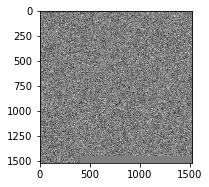

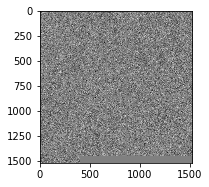

Epoch: 001/59700 cost: 80707.984000000
Epoch: 002/59700 cost: 48904.500000000
Epoch: 003/59700 cost: 28770.664000000
Epoch: 004/59700 cost: 18627.706000000
Epoch: 005/59700 cost: 12923.586000000
Epoch: 006/59700 cost: 10397.274000000
Epoch: 007/59700 cost: 15066.508000000
Epoch: 008/59700 cost: 22239.330000000
Epoch: 009/59700 cost: 22342.384000000
Epoch: 010/59700 cost: 15756.920000000
Epoch: 011/59700 cost: 13843.140000000
Epoch: 012/59700 cost: 16664.512000000
Epoch: 013/59700 cost: 16144.190000000
Epoch: 014/59700 cost: 12630.946000000
Epoch: 015/59700 cost: 8830.222000000
Epoch: 016/59700 cost: 6948.028000000
Epoch: 017/59700 cost: 6584.117000000
Epoch: 018/59700 cost: 5696.594000000
Epoch: 019/59700 cost: 4353.145000000
Epoch: 020/59700 cost: 4152.978750000
Epoch: 021/59700 cost: 4528.340000000
Epoch: 022/59700 cost: 3821.669500000
Epoch: 023/59700 cost: 2745.501000000
Epoch: 024/59700 cost: 2568.184000000
Epoch: 025/59700 cost: 3061.540500000
Epoch: 026/59700 cost: 3109.34850000

In [ ]:
batch_size = 1000
training_epochs = 300 * (ntrain/batch_size)
SMALL = 0.000001

with tf.Session() as sess:
    import pylab
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(training_epochs):
        randidx  = np.random.randint(ntrain, size=batch_size).astype('int32')
        batch_x1s = X1[randidx]
        batch_x2s = X2[randidx]  
        sess.run(optimizer_1, feed_dict={input_x1: batch_x1s.astype('float32'), input_x2: batch_x2s.astype('float32')})
        sess.run(normalize_U1)
        sess.run(normalize_V1)
        
        cost_ = sess.run(cost_1, feed_dict={input_x1: batch_x1s.astype('float32'), input_x2: batch_x2s.astype('float32')}) / batch_size
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch,training_epochs ,cost_) ) 
        
        if epoch % 1000 == 0 :
            pylab.subplot(1, 2, 1)
            dispims(U1.eval(sess), 64, 64, 2)
            pylab.subplot(1, 2, 2)
            dispims(V1.eval(sess), 64, 64, 2)
    np.save("U1", np.array(U1.eval(sess)))
    np.save("V1", np.array(V1.eval(sess)))
    np.save("W1", np.array(W1.eval(sess)))
    np.save("bias_U1", np.array(bias_U1.eval(sess)))
    np.save("bias_V1", np.array(bias_V1.eval(sess)))
    np.save("bias_W1", np.array(bias_W1.eval(sess)))
    np.save("bias_U1_out", np.array(bias_U1_out.eval(sess)))
    np.save("bias_V1_out", np.array(bias_V1_out.eval(sess)))
    np.save("bias_W1_out", np.array(bias_W1_out.eval(sess)))